In [1]:
### Libraries

# Misc.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
import seaborn as sns
import datetime as dt
import os

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import class_weight

# Dimension Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, SpectralEmbedding, TSNE

# Models
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
import xgboost as xgb

# Evaluation
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
### Read data

data_path = f'{os.path.dirname(os.getcwd())}/data'
train_df = pd.read_csv(f'{data_path}/train.csv')
test_df = pd.read_csv(f'{data_path}/test.csv')

### Clean Information

def clean(df: pd.DataFrame):
    # Drop NaNs from beds and bathrooms_text columns
    df.dropna(subset = ['beds', 'bathrooms_text'], inplace = True)

    # Group hotel and shared rooms into 'other' category
    rooms_regrouped = df['room_type'].where((df['room_type'] == 'Entire home/apt') | (df['room_type'] == 'Private room'), 'Other')
    df['rooms_regrouped'] = rooms_regrouped
    df['entire_bin'] = np.where(df['rooms_regrouped'] == 'Entire home/apt', 1, 0)
    df['private_bin'] = np.where(df['rooms_regrouped'] == 'Private room', 1, 0)
    df['other_room_bin'] = np.where(df['rooms_regrouped'] == 'Other', 1, 0)

    # Extract 'shared' keyword from bathrooms_text column
    def shared_bathrooms(row):
        if type(row['bathrooms_text']) is not str or 'shared' not in row['bathrooms_text']:
            return 0
        return 1
    df['bathrooms_shared'] = df.apply(shared_bathrooms, axis = 1)

    # Extract number of baths from bathrooms_text column
    def extract_num(row):
        char_arr = np.array(row['bathrooms_text'].split())
        res = char_arr[np.char.isnumeric(char_arr)].astype(float)
        return res[0] if res.size != 0 else 1 # HOW TO IMPUTE TEXT-ONLY SAMPLES
    df['bathrooms_num'] = df.apply(extract_num, axis = 1)

    # Extract number of amenities from amenities column
    def extract_amenities(row):
        return set(row['amenities'][2:-2].split('''", "'''))
    df['amenities_ref'] = df.apply(extract_amenities, axis = 1)
    def count_amenities(row):
        return len(row['amenities_ref'])
    df['amenities_count'] = df.apply(count_amenities, axis = 1)

clean(train_df)
clean(test_df)

In [3]:
### Pull out relevant features identified in EDA

features = ['host_listings_count', 'calculated_host_listings_count_private_rooms', 'entire_bin', 'private_bin', 'other_room_bin', 'accommodates', 'bathrooms_shared', 'bathrooms_num', 
            'beds', 'amenities_count', 'latitude', 'longitude', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'availability_30', 'availability_365', 
            'neighbourhood_cleansed', 'property_type', 'host_id', 'price']
target = 'price'

### Split training data
X_train, X_test, y_train, y_test = train_test_split(train_df[features], train_df[target], test_size = 0.2)

impute_features = ['host_listings_count', 'calculated_host_listings_count_private_rooms', 'entire_bin', 'private_bin', 'other_room_bin', 'accommodates', 'bathrooms_shared',
                   'bathrooms_num', 'beds', 'amenities_count', 'latitude', 'longitude', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'availability_30', 
                   'availability_365']
regional_metrics_knn_df = X_train[impute_features]
regional_metrics_knn_df = MinMaxScaler().fit_transform(X = regional_metrics_knn_df)
nearest_neighbors = NearestNeighbors(n_neighbors = 16).fit(X = regional_metrics_knn_df)

def impute_nans(row, feature, metric):
    if np.isnan(row[feature]):
        neighbors = nearest_neighbors.kneighbors(row[impute_features].values.reshape(1, -1), return_distance = False)
        if metric == 'mean':
            return X_train[feature].iloc[list(neighbors[0])].mean()
        if metric == 'median':
            return X_train[feature].iloc[list(neighbors[0])].median()
    else:
        return row[feature]

threshold = 20

mean_neighborhood_price = X_train[['neighbourhood_cleansed', 'price']].groupby(by = 'neighbourhood_cleansed').mean().to_dict()['price']
median_neighborhood_price = X_train[['neighbourhood_cleansed', 'price']].groupby(by = 'neighbourhood_cleansed').median().to_dict()['price']
neighborhood_counts = X_train['neighbourhood_cleansed'].value_counts()
for neighborhood in neighborhood_counts.index:
    if neighborhood_counts[neighborhood] < threshold:
        mean_neighborhood_price.pop(neighborhood, None)
        median_neighborhood_price.pop(neighborhood, None)
X_train['mean_neighborhood_price'] = X_train['neighbourhood_cleansed'].map(mean_neighborhood_price)
X_train['median_neighborhood_price'] = X_train['neighbourhood_cleansed'].map(median_neighborhood_price)
X_train['mean_neighborhood_price'] = X_train.apply(impute_nans, args = ('mean_neighborhood_price', 'mean'), axis = 1)
X_train['median_neighborhood_price'] = X_train.apply(impute_nans, args = ('median_neighborhood_price', 'median'), axis = 1)

threshold = 20

mean_property_type_price = X_train[['property_type', 'price']].groupby(by = 'property_type').mean().to_dict()['price']
median_property_type_price = X_train[['property_type', 'price']].groupby(by = 'property_type').median().to_dict()['price']
property_counts = X_train['property_type'].value_counts()
for property in property_counts.index:
    if property_counts[property] < threshold:
        mean_property_type_price.pop(property, None)
        median_property_type_price.pop(property, None)
X_train['mean_property_type_price'] = X_train['property_type'].map(mean_property_type_price)
X_train['median_property_type_price'] = X_train['property_type'].map(median_property_type_price)
X_train['mean_property_type_price'] = X_train.apply(impute_nans, args = ('mean_property_type_price', 'mean'), axis = 1)
X_train['median_property_type_price'] = X_train.apply(impute_nans, args = ('median_property_type_price', 'median'), axis = 1)

threshold = 10

#mean_host_id_price = X_train[['host_id', 'price']].groupby(by = 'host_id').mean().to_dict()['price']
#median_host_id_price = X_train[['host_id', 'price']].groupby(by = 'host_id').median().to_dict()['price']
#host_counts = X_train['host_id'].value_counts()
#for host_id in host_counts.index:
#    if host_counts[host_id] < threshold:
#        mean_host_id_price.pop(host_id, None)
#        median_host_id_price.pop(host_id, None)
#X_train['mean_host_id_price'] = X_train['host_id'].map(mean_host_id_price)
#X_train['median_host_id_price'] = X_train['host_id'].map(median_host_id_price)

/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprec

In [5]:
### Extraction of mean/median prices by categorical features

nearest_neighbors = NearestNeighbors(n_neighbors = 16).fit(X = regional_metrics_knn_df)

X_test['mean_neighborhood_price'] = X_test['neighbourhood_cleansed'].map(mean_neighborhood_price)
X_test['mean_neighborhood_price'] = X_test.apply(impute_nans, args = ('mean_neighborhood_price', 'mean'), axis = 1)

X_test['median_neighborhood_price'] = X_test['neighbourhood_cleansed'].map(median_neighborhood_price)
X_test['median_neighborhood_price'] = X_test.apply(impute_nans, args = ('median_neighborhood_price', 'median'), axis = 1)

X_test['mean_property_type_price'] = X_test['property_type'].map(mean_property_type_price)
X_test['mean_property_type_price'] = X_test.apply(impute_nans, args = ('mean_property_type_price', 'mean'), axis = 1)

X_test['median_property_type_price'] = X_test['property_type'].map(median_property_type_price)
X_test['median_property_type_price'] = X_test.apply(impute_nans, args = ('median_property_type_price', 'median'), axis = 1)

#X_test['mean_host_id_price'] = X_test['host_id'].map(mean_host_id_price)
#X_test['mean_host_id_price'] = X_test.apply(impute_nans, args = ('mean_host_id_price', 'mean'), axis = 1)

#X_test['median_host_id_price'] = X_test['host_id'].map(median_host_id_price)
#X_test['median_host_id_price'] = X_test.apply(impute_nans, args = ('median_host_id_price', 'mean'), axis = 1)

X_train = X_train.drop(['neighbourhood_cleansed', 'property_type', 'host_id', 'price'], axis = 1)
X_test = X_test.drop(['neighbourhood_cleansed', 'property_type', 'host_id', 'price'], axis = 1)

ss = StandardScaler().fit(X = X_train)
X_train = pd.DataFrame(ss.transform(X = X_train), index = X_train.index, columns = X_train.columns)
X_test = pd.DataFrame(ss.transform(X = X_test), index = X_test.index, columns = X_test.columns)

/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprec

### Fit clustering methods identified in EDA to training set

embedding_features = ['accommodates', 'bathrooms_num', 'beds', 'latitude', 'longitude']
embedding_df = X_train[embedding_features]
#mms = MinMaxScaler().fit(X = embedding_df)
ss = StandardScaler().fit(X = embedding_df)
#embedding_df = mms.transform(embedding_df)
embedding_df = ss.transform(embedding_df)

# Spectral Embedding with KNN
spectral_knn_embedding = SpectralEmbedding(n_components = 2, affinity = 'nearest_neighbors', n_neighbors = 15).fit(X = embedding_df)

# Isomap
isomap_embedding = Isomap(n_neighbors = 15, n_components = 2).fit(X = embedding_df)

# PCA
pca_embedding = PCA(n_components = 2).fit(X = embedding_df)

# TSNE
tsne_embedding = TSNE(n_components = 2, perplexity = 50, n_iter = 1000).fit(X = embedding_df)

# PCA
embedding_features = ['accommodates', 'bathrooms_num', 'beds', 'latitude', 'longitude']
embedding_df = X_train[embedding_features]
#mms = MinMaxScaler().fit(X = embedding_df)
ss = StandardScaler().fit(X = embedding_df)
#embedding_df = mms.transform(embedding_df)
embedding_df = ss.transform(embedding_df)
pca_embedding = PCA(n_components = 2).fit(X = embedding_df)
X_train['pca_embedding_x'], X_train['pca_embedding_y'] = pca_embedding.transform(X = embedding_df)[:,0], pca_embedding.transform(X = embedding_df)[:,1]
X_test['pca_embedding_x'], X_test['pca_embedding_y'] = pca_embedding.transform(X = embedding_df_test)[:,0], pca_embedding.transform(X = embedding_df_test)[:,1]

X_train['spectral_knn_embedding_x'], X_train['spectral_knn_embedding_y'] = spectral_knn_embedding.embedding_[:,0], spectral_knn_embedding.embedding_[:,1]
X_train['isomap_embedding_x'], X_train['isomap_embedding_y'] = isomap_embedding.embedding_[:,0], isomap_embedding.embedding_[:,1]
X_train['pca_embedding_x'], X_train['pca_embedding_y'] = pca_embedding.transform(X = embedding_df)[:,0], pca_embedding.transform(X = embedding_df)[:,1]
X_train['tsne_embedding_x'], X_train['tsne_embedding_y'] = tsne_embedding.embedding_[:,0], tsne_embedding.embedding_[:,1]

#mms = MinMaxScaler().fit(X = X_train)
ss = StandardScaler().fit(X = X_train)
X_train = pd.DataFrame(ss.transform(X = X_train), index = X_train.index, columns = X_train.columns)

### Fit clustering methods identified in EDA to testing set

embedding_df_test = X_test[embedding_features]

# Spectral Embedding with KNN
spectral_knn_embedding_test = SpectralEmbedding(n_components = 2, affinity = 'nearest_neighbors', n_neighbors = 15).fit(X = embedding_df_test)

# Isomap
isomap_embedding_test = Isomap(n_neighbors = 15, n_components = 2).fit(X = embedding_df_test)

# PCA

# TSNE
tsne_embedding_test = TSNE(n_components = 2, perplexity = 50, n_iter = 1000).fit(X = embedding_df_test)

X_test['spectral_knn_embedding_x'], X_test['spectral_knn_embedding_y'] = spectral_knn_embedding_test.embedding_[:,0], spectral_knn_embedding_test.embedding_[:,1]
X_test['isomap_embedding_x'], X_test['isomap_embedding_y'] = isomap_embedding_test.embedding_[:,0], isomap_embedding_test.embedding_[:,1]
X_test['pca_embedding_x'], X_test['pca_embedding_y'] = pca_embedding.transform(X = embedding_df_test)[:,0], pca_embedding.transform(X = embedding_df_test)[:,1]
X_test['tsne_embedding_x'], X_test['tsne_embedding_y'] = tsne_embedding_test.embedding_[:,0], tsne_embedding_test.embedding_[:,1]

X_test = pd.DataFrame(ss.transform(X = X_test), index = X_test.index, columns = X_test.columns)

Some random models for my own understanding (and entertainment)

In [755]:
linear_clf = LinearRegression().fit(X = X_train, y = y_train)
y_pred_linear = linear_clf.predict(X = X_test)
linear_acc = balanced_accuracy_score(y_true = y_test, y_pred = np.round(y_pred_linear))

/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprec

In [756]:
print(f'Linear Regression Accuracy: {linear_acc}')

Linear Regression Accuracy: 0.3485325834931585


In [757]:
logistic_clf = LogisticRegression().fit(X = X_train, y = y_train)
y_pred_logistic = logistic_clf.predict(X = X_test)
logistic_acc = balanced_accuracy_score(y_true = y_test, y_pred = y_pred_logistic)

/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprec

In [758]:
print(f'Logistic Regression Accuracy: {logistic_acc}')

Logistic Regression Accuracy: 0.4385208727555882


In [759]:
tree_clf = DecisionTreeClassifier(min_samples_split = 1501).fit(X = X_train, y = y_train)
y_pred_tree = tree_clf.predict(X = X_test)
tree_acc = balanced_accuracy_score(y_true = y_test, y_pred = y_pred_tree)

/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprec

In [760]:
print(f'Decision Tree Accuracy: {tree_acc}')

Decision Tree Accuracy: 0.3880396975379478


In [578]:
adaboost_estimator = DecisionTreeClassifier(max_depth = 1)
adaboost_clf = AdaBoostClassifier(estimator = adaboost_estimator, n_estimators = 1000).fit(X = X_train, y = y_train)
y_pred_adaboost = adaboost_clf.predict(X = X_test)
adaboost_acc = balanced_accuracy_score(y_true = y_test, y_pred = y_pred_adaboost)

/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprec

In [579]:
print(f'AdaBoost Accuracy: {adaboost_acc}')

AdaBoost Accuracy: 0.308233335788292


In [7]:
xgb_params = {
    'n_estimators': [500, 750, 1000],
    'max_depth': [2, 3, 5, 7, 8],
}
#xgb_cv = GridSearchCV(xgb.XGBClassifier(), param_grid = xgb_params, scoring = 'accuracy', n_jobs = 3).fit(X = X_train, y = y_train)
#xgb_clf = xgb_cv.best_estimator_

In [898]:
classes_weights = class_weight.compute_sample_weight(class_weight = 'balanced', y = y_train)
xgb_clf = xgb.XGBClassifier(n_estimators = 500, max_depth = 8, learning_rate = 0.1, reg_lambda = 0.7).fit(X = X_train, y = y_train, sample_weight = classes_weights) 
y_pred_xgb = xgb_clf.predict(X = X_test)

/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/xgboost/data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/xgboost/data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/xgboost/data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categor

In [899]:
xgb_acc = balanced_accuracy_score(y_true = y_test, y_pred = y_pred_xgb)
print(f'XGBoost Accuracy: {xgb_acc}')

XGBoost Accuracy: 0.5138963212625955


/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Che

In [10]:
rf_params = {
    'n_estimators': [15, 25, 75, 125, 500, 750, 1000],
    'max_depth': [2, 3, 5, 7, 8],
}
#rf_cv = GridSearchCV(RandomForestClassifier(), param_grid = rf_params, scoring = 'accuracy').fit(X = X_train, y = y_train)

/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprec

Text(0.5, 1.0, 'Random Forest Balanced Accuracy vs. Number of Trees')

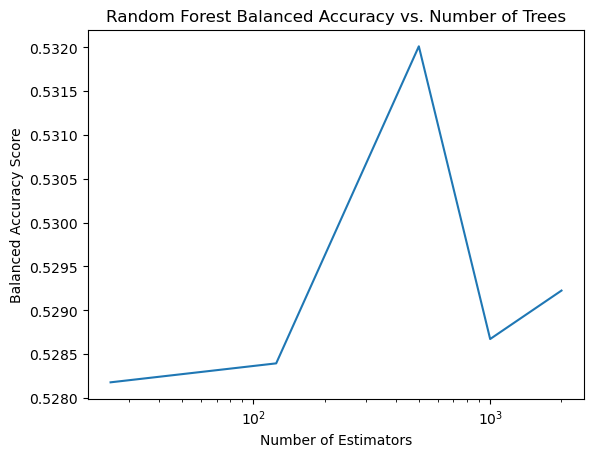

In [6]:
estimator_nums = [25, 125, 500, 1000, 2000]
rf_accs = []
for n in [25, 125, 500, 1000, 2000]:
    rf_clf = RandomForestClassifier(n_estimators = 500).fit(X = X_train, y = y_train)
    y_pred_rf = rf_clf.predict(X = X_test)
    rf_acc = balanced_accuracy_score(y_true = y_test, y_pred = y_pred_rf)
    rf_accs.append(rf_acc)
plt.plot(estimator_nums, rf_accs)
plt.xscale('log')
plt.xlabel('Number of Estimators')
plt.ylabel('Balanced Accuracy Score')
plt.title('Random Forest Balanced Accuracy vs. Number of Trees')

/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprec

Text(0.5, 1.0, 'Random Forest Balanced Accuracy vs. Maximum Depth')

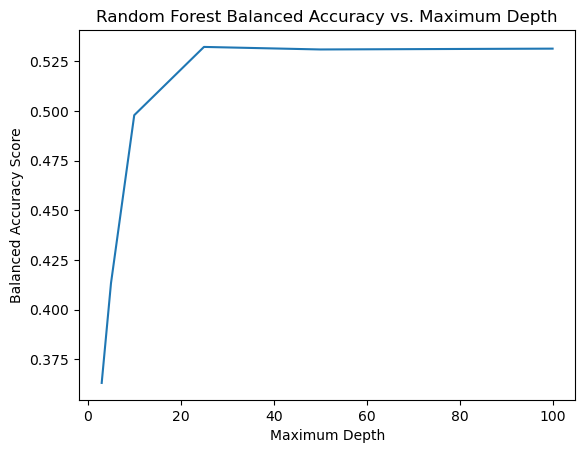

In [11]:
max_depth = [3, 5, 10, 25, 50, 100]
rf_accs = []
for d in max_depth:
    rf_clf = RandomForestClassifier(n_estimators = 500, max_depth = d).fit(X = X_train, y = y_train)
    y_pred_rf = rf_clf.predict(X = X_test)
    rf_acc = balanced_accuracy_score(y_true = y_test, y_pred = y_pred_rf)
    rf_accs.append(rf_acc)
plt.plot(max_depth, rf_accs)
plt.xlabel('Maximum Depth')
plt.ylabel('Balanced Accuracy Score')
plt.title('Random Forest Balanced Accuracy vs. Maximum Depth')

/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/xgboost/data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/xgboost/data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/xgboost/data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categor

Text(0.5, 1.0, 'XGBoost Balanced Accuracy vs. Number of Trees')

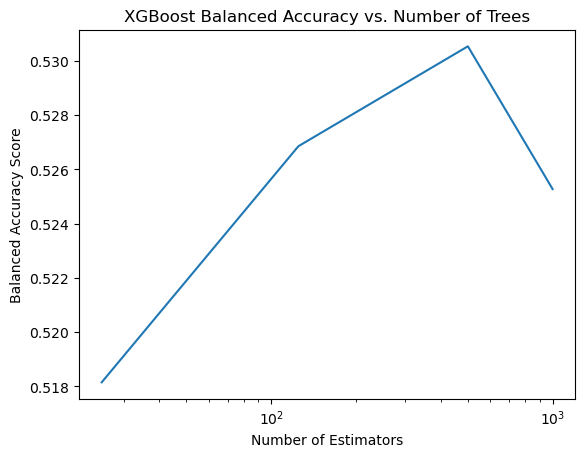

In [14]:
classes_weights = class_weight.compute_sample_weight(class_weight = 'balanced', y = y_train)

estimator_nums = [25, 125, 500, 1000]
xgb_accs = []
for n in estimator_nums:
    xgb_clf = xgb.XGBClassifier(n_estimators = n, max_depth = 8, learning_rate = 0.1, reg_lambda = 0.7).fit(X = X_train, y = y_train, sample_weight = classes_weights) 
    y_pred_xgb = xgb_clf.predict(X = X_test)
    xgb_acc = balanced_accuracy_score(y_true = y_test, y_pred = y_pred_xgb)
    xgb_accs.append(xgb_acc)
plt.plot(estimator_nums, xgb_accs)
plt.xscale('log')
plt.xlabel('Number of Estimators')
plt.ylabel('Balanced Accuracy Score')
plt.title('XGBoost Balanced Accuracy vs. Number of Trees')

/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/xgboost/data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/xgboost/data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/opt/anaconda3/envs/cs671_final_project/lib/python3.9/site-packages/xgboost/data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categor

Text(0.5, 1.0, 'XGBoost Balanced Accuracy vs. Maximum Depth')

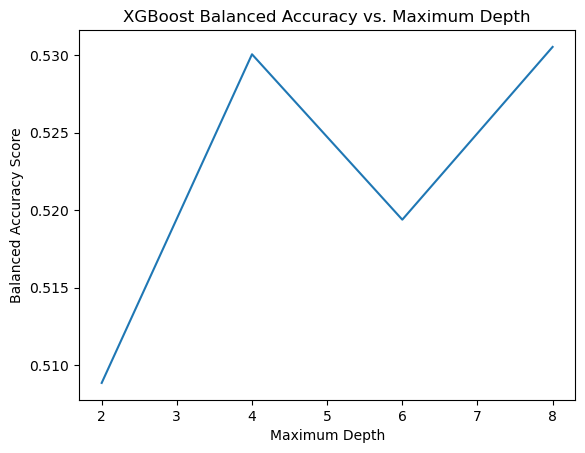

In [13]:
max_depth = [2, 4, 6, 8]
xgb_accs = []
for d in max_depth:
    xgb_clf = xgb.XGBClassifier(n_estimators = 500, max_depth = d, learning_rate = 0.1, reg_lambda = 0.7).fit(X = X_train, y = y_train, sample_weight = classes_weights) 
    y_pred_xgb = xgb_clf.predict(X = X_test)
    xgb_acc = balanced_accuracy_score(y_true = y_test, y_pred = y_pred_xgb)
    xgb_accs.append(xgb_acc)
plt.plot(max_depth, xgb_accs)
plt.xlabel('Maximum Depth')
plt.ylabel('Balanced Accuracy Score')
plt.title('XGBoost Balanced Accuracy vs. Maximum Depth')